In [1]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

In [2]:
image = cv2.imread('../forms/form.png')
max_size = 3000

height, width = image.shape[:2]

if width > height:
    new_width = max_size
    ratio = max_size / width
    new_height = int(height * (max_size / width))
else:
    new_height = max_size
    ratio = max_size / height
    new_width = int(width * (max_size / height))
og_image = image.copy()
resized_image = cv2.resize(image, (new_width, new_height))
gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

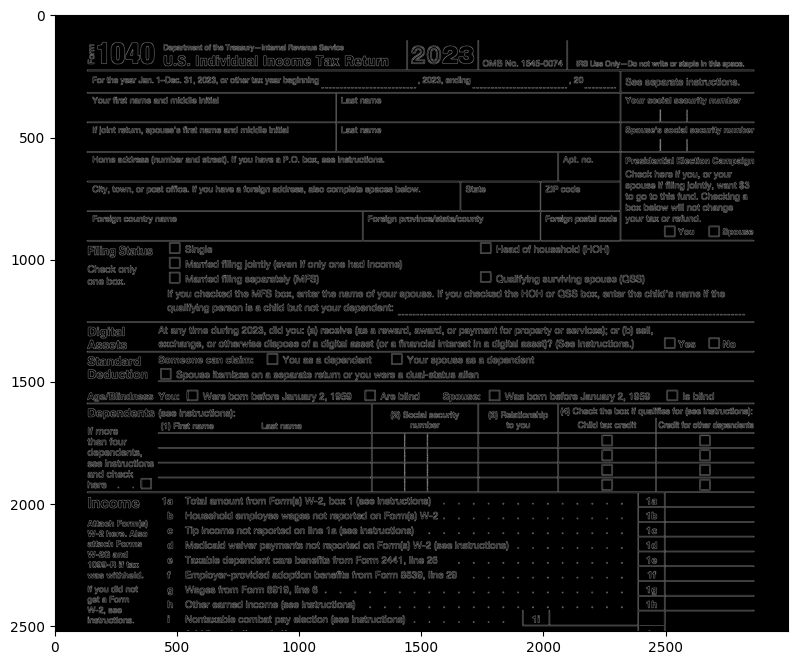

In [3]:
edges = cv2.Canny(blurred, 50, 100)

cv2.imwrite('edges.png', edges)

plt.figure(figsize=(10, 8))
plt.imshow(edges, cmap='gray')
plt.show()

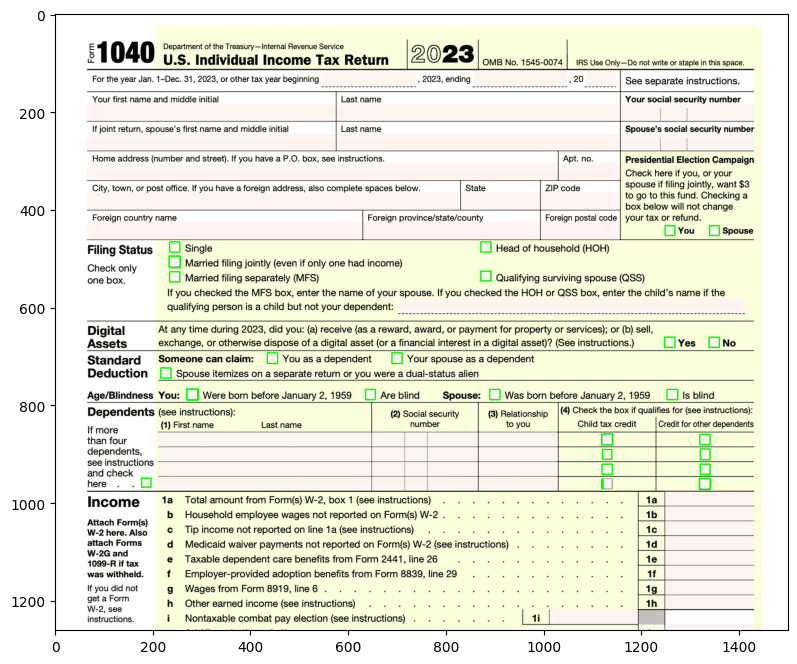

In [4]:
rectangles = []
contours, hierarchy = cv2.findContours(
    edges.copy(), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
last_children = []


def explore_hierarchy(contour_index, hierarchy, contours, last_children):
    if hierarchy[0][contour_index][2] != -1:
        child_index = hierarchy[0][contour_index][2]
        explore_hierarchy(child_index, hierarchy, contours, last_children)
    else:
        last_children.append(contours[contour_index])


for i, contour in enumerate(contours):
    epsilon = 0.03 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / float(h)
    contour_area = w * float(h)
    if (len(approx) == 4 and 0.9 <= aspect_ratio <= 1.1 and 1000 <= contour_area <= 3000):
        explore_hierarchy(i, hierarchy, contours, last_children)
        for rect in last_children:
            x, y, w, h = cv2.boundingRect(rect)
            rectangles.append((x, y, x + w, y + h))

grouped_rectangles, weights = cv2.groupRectangles(
    rectangles, groupThreshold=1, eps=0.03)

for rect in grouped_rectangles:
    x1, y1, x2, y2 = map(lambda coord: int(coord / ratio), rect)
    cv2.rectangle(og_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize=(10, 8))
plt.imshow(og_image)
plt.show()

In [5]:
image = resized_image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 100, 150)

In [6]:
data = pytesseract.image_to_data(edges, output_type=pytesseract.Output.DICT, config='--psm 11')

filtered_boxes = []
for i in range(len(data['level'])):
    (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
    confidence = int(data['conf'][i])
    if 500 >= w * h:
        continue
    aspect_ratio = float(w) / h
    if 1.1 >= aspect_ratio:
        continue
    if 1 > confidence: 
        continue
    filtered_boxes.append((x, y, w, h))
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

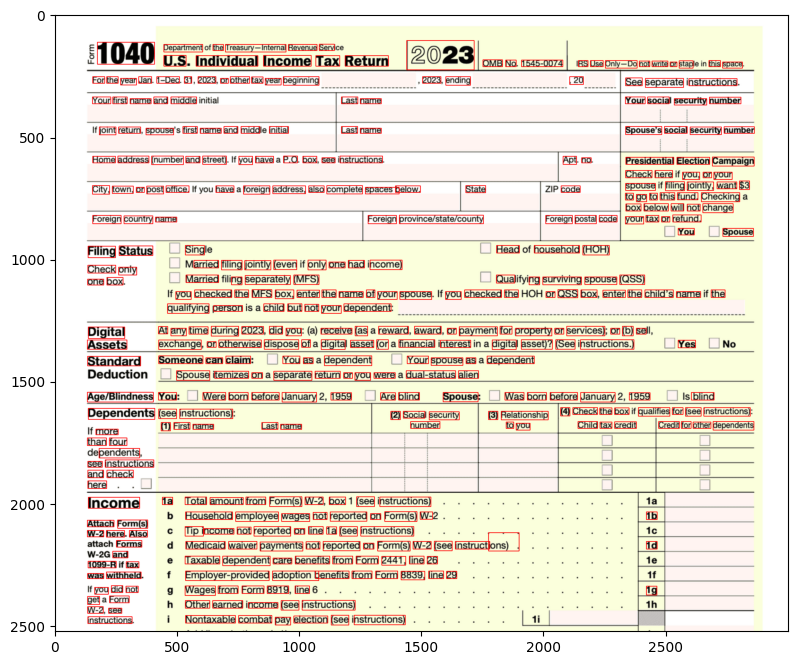

In [7]:
plt.figure(figsize=(10, 8))
plt.imshow(image, cmap='gray')
plt.show()

In [8]:
def line_intersects_box(line, box):
    line_x1, line_y1, line_x2, line_y2 = line
    box_x, box_y, box_w, box_h = box

    if (box_x <= line_x1 <= box_x + box_w and box_y <= line_y1 <= box_y + box_h) or \
       (box_x <= line_x2 <= box_x + box_w and box_y <= line_y2 <= box_y + box_h):
        return True


    return False  

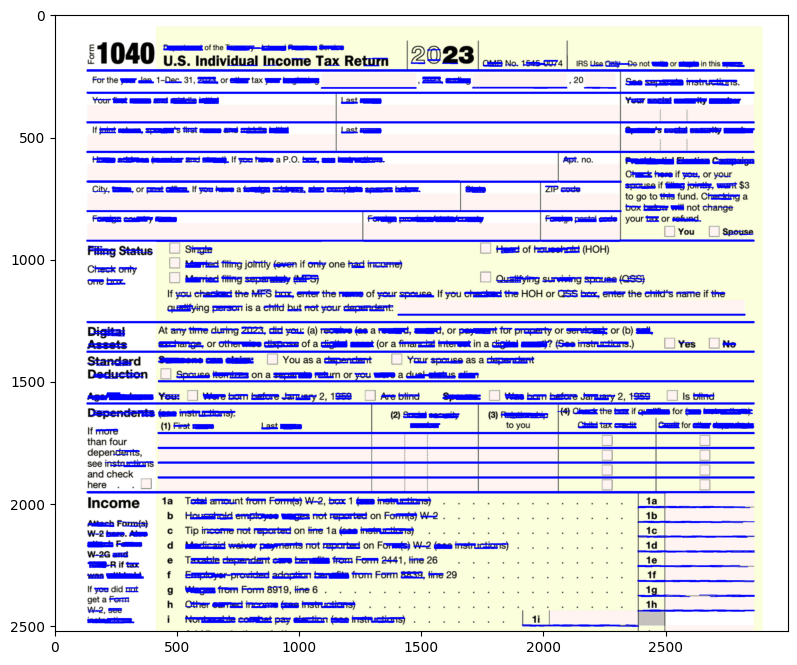

In [9]:
img_copy = resized_image.copy()
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # 3x3 rectangular kernel
dilated_image = cv2.dilate(edges, kernel, iterations=1)
lines = cv2.HoughLinesP(dilated_image, 1, np.pi/180, threshold=180, minLineLength=50, maxLineGap=5)

vertical_lines = filter(lambda line: abs(line[0][3] - line[0][1]) < 5, lines)
sorted_lines = sorted(vertical_lines, key=lambda line: line[0][1])
for line in sorted_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.figure(figsize=(10, 8))
plt.imshow(img_copy)
plt.show()

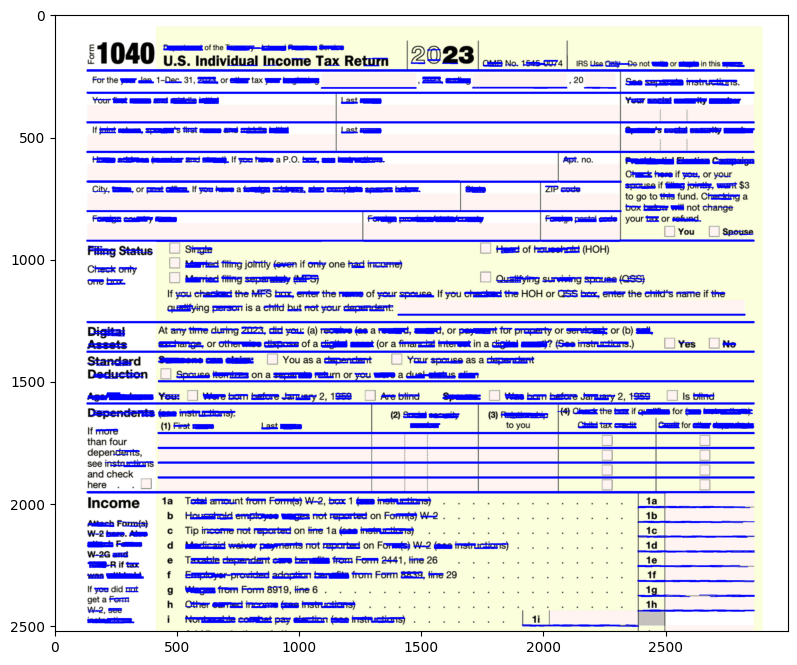

In [10]:
aggregated_lines = [];
for i, line in enumerate(sorted_lines):
    x1, y1, x2, y2 = line[0]
    if i == 0:
        aggregated_lines.append(line[0])
    elif abs(y1 - aggregated_lines[-1][3]) > 50:
        aggregated_lines.append(line[0])
    elif (x2 - 10 < aggregated_lines[-1][0] or x1 + 10 > aggregated_lines[-1][2]):
        aggregated_lines.append(line[0])

for line in aggregated_lines:
    x1, y1, x2, y2 = line
    cv2.line(img_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)


plt.figure(figsize=(10, 8))
plt.imshow(img_copy)
plt.show()

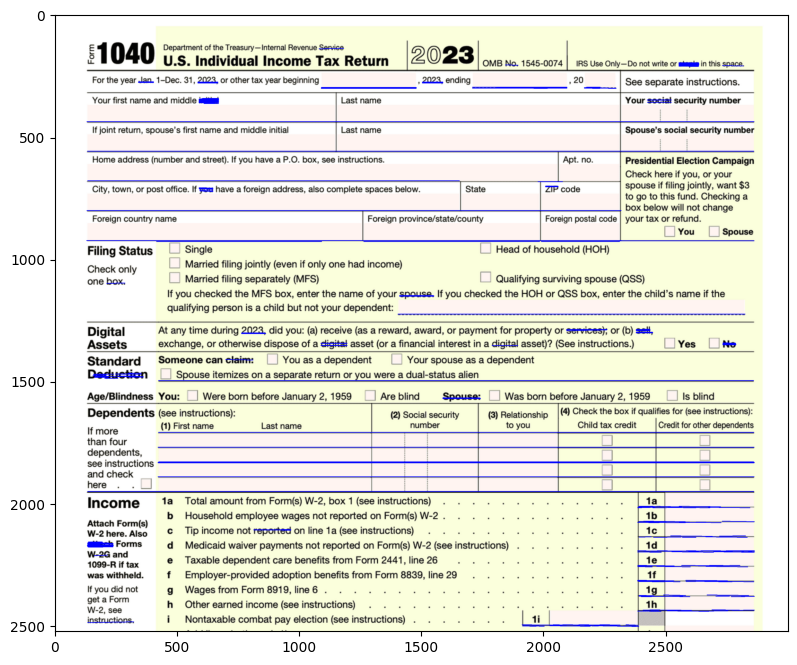

In [11]:
for line in aggregated_lines:
    x1, y1, x2, y2 = line
    intersects_box = False
    for box in filtered_boxes:
        if line_intersects_box((x1, y1, x2, y2), box):
            intersects_box = True
            break

    if not intersects_box:
        cv2.line(resized_image, (x1, y1), (x2, y2), (0, 0, 255), 2)


plt.figure(figsize=(10, 8))
plt.imshow(resized_image)
plt.show()